# Module 0: Generation of synthetic metabolomics & proteomics time-series data based on predetermined models

# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='G3PCX_K_Linlog_'
all_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']
all_metabolites = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

# Import needed libraries

In [2]:
from IPython.display import display
import pandas as pd
from plot import *
import seaborn as sns
import math

# Define kinetic model

ODEs of limonene pathway reactions as provided by Costello et al. 2018 & in the same order. 

Provided here to facilitate understanding & reconstruction of ODEs.

In [3]:
from KineticLearning import leaky_hill_fcn, proteomicsData
    
def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                   k11,k12,
                   k21,k22,k23,
                   k31,k32,k33,k34,
                   k41,k42,k43,k44,
                   k51,k52,
                   k61,k62,k63,k64,
                   k71,k72,
                   k81,k82,k83,
                   k91,k92,
                   Vin): #HC: 27

    r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
    r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
    r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
    r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
    r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
    r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
    r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
    r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
    r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
    r10 = 10**Vin # AcCoA supply

    # net metabolite turnover in Costello et al.
    rs1 = r10 - r1 - r2     
    rs2 = r1 - r2
    rs3 = r2 - r3
    rs4 = r3 - r4
    rs5 = r4 - r5
    rs6 = r5 - r6
    rs7 = r6 - r7 - r8
    rs8 = r7 - r8
    rs9 = r8 - r9
    rs10 = r9

    return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
    
def kinetic_model_xtk(s,t,k):

    # Return rate of reaction vector (r1, r2, ..., r10) based on e,s,kr
    # s: metabolites conc vector
    # t: time point for getting enzymes conc
    # k: rate law parameters vector ('ke' followed by 'kr')
    
    #print('len of param vec',len(k))
    #print('KineticCoefficients',k[3*9:],len(k[3*9:]))
    #print('Proteomics',k[:3*9],len(k[:3*9]))
    
    # get e
    ke = k[:3*9] #HC: 3 ke values for each of 9 enzymes
    e = proteomicsData(t,ke)
    
    # get kr
    kr = k[3*9:] #HC: rest of k are krs
    #HC: check e,s,kr
    #print(len(e),len(x),len(kr))

    return kinetic_model(*e,*s,*kr) # list of 'r' 

# * SET rate constant kr

In [4]:
# G3PCX 0% noise
kr=[-7.900742943333333,
 -8.400988573333334,
 -7.6014103099999994,
 -8.79977012,
 -8.301672323333333,
 -7.10760661,
 -8.0999399,
 -10.383119396666666,
 -7.707053429999999,
 -6.806362383333333,
 -7.30669661,
 -8.004376383333332,
 -7.9083689999999995,
 -6.8046178033333335,
 -7.404648433333333,
 -7.40956479,
 -7.899632626666666,
 -9.069975136666667,
 -8.384111110000001,
 -6.502307706666667,
 -7.30233268,
 -6.718441853333334,
 -7.51860529,
 -11.999999153333334,
 -7.320815083333333,
 -7.821748626666667, -1.30103]

print (str(len(kr))+' kr parameters in same order as their input into kinetic_model function:')
print (kr)

27 kr parameters in same order as their input into kinetic_model function:
[-7.900742943333333, -8.400988573333334, -7.6014103099999994, -8.79977012, -8.301672323333333, -7.10760661, -8.0999399, -10.383119396666666, -7.707053429999999, -6.806362383333333, -7.30669661, -8.004376383333332, -7.9083689999999995, -6.8046178033333335, -7.404648433333333, -7.40956479, -7.899632626666666, -9.069975136666667, -8.384111110000001, -6.502307706666667, -7.30233268, -6.718441853333334, -7.51860529, -11.999999153333334, -7.320815083333333, -7.821748626666667, -1.30103]


# * SET Ke parameters (kf, kl, km) for WT

e = kf * t / (km + t)   + kl <br>
where kf: maximum increase in enzyme conc <br>
km: hours required to increase the enzyme conc by 1/2*kf <br>
kl: enzyme conc at hour = 0

1. define km parameters

- km: randomly SET between 0.1 t & 9 hours

- kf: randomly initialized between 1e5 & 1e6                                              

- kl: randomly SET between 1e1 to 1e2

In [5]:
#--- set initial parameter bounds for each enzyme
bounds = [(1e6,5e6),(0.1,1),(1e1,1e2)]*9
lower_bound = [bound[0] for bound in bounds] # reformat bounds
upper_bound = [bound[1] for bound in bounds]

# For creating replicable WT template, NOT noise !!
np.random.seed(2)

# get random kf, km, kl values based on bounds
ke = np.random.uniform(low=lower_bound,high=upper_bound)

print('km values defined...\n\nkf, kl values initialized for ' + str(int(len(ke)/3)) + ' enzymes:')
print (ke)

km values defined...

kf, kl values initialized for 9 enzymes:
[2.74397961e+06 1.23333609e-01 5.94696230e+01 2.74128957e+06
 4.78331022e-01 3.97301339e+01 1.81859454e+06 6.57343870e-01
 3.69689206e+01 2.06730910e+06 6.59020449e-01 5.76227885e+01
 1.53831978e+06 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 4.38624594e+06 1.71680929e-01
 5.54721481e+01 1.26114602e+06 4.85310095e-01 1.86877824e+01
 1.50863989e+06 6.37070778e-01 3.03410801e+01]


2. define kl parameters
- i.e., enzyme expression values at t =0 from the 3 empirical strains

3. define kf parameters

# --- SET data points requirement for synthetic data

In [6]:
# no. data points needed per hour
datapointsPerHr = 4

# no. hours required
hr = 24

# resulting total no. data points required
noDataPts=hr*datapointsPerHr + 1 # include data for time=0

# Generate array of evenly-spaced time points betw max & min time
timePoints = np.linspace(0,hr,noDataPts)

# --- SET biological noise

For all strains, affects:
- initial enzyme conc (kl values)
- initial metabolite conc

In [7]:
biologicalNoise = 0.0 # 0.025: Gaussian noise with standard deviation of 2.5% of underlying value
biologicalNoiseSeed = 0

# Explore synthetic time-series data for enzymes in WT

to appreciate effects of kf, km, kl

no. time series: 9
data points in each time series:97

AtoB


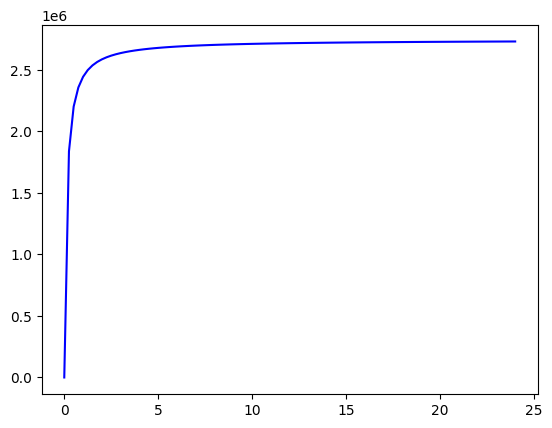

HMGS


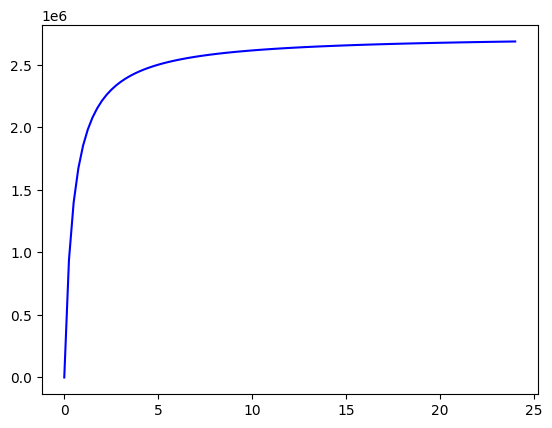

HMGR


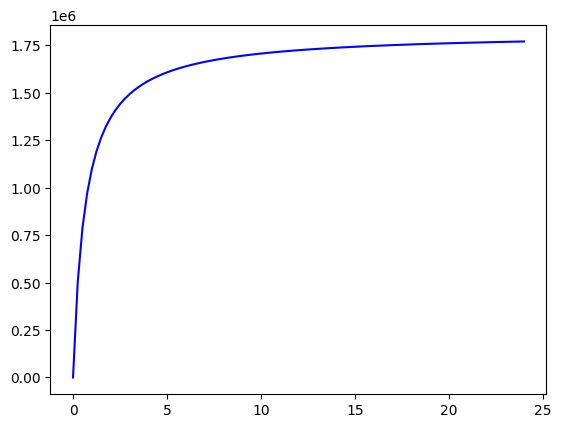

MK


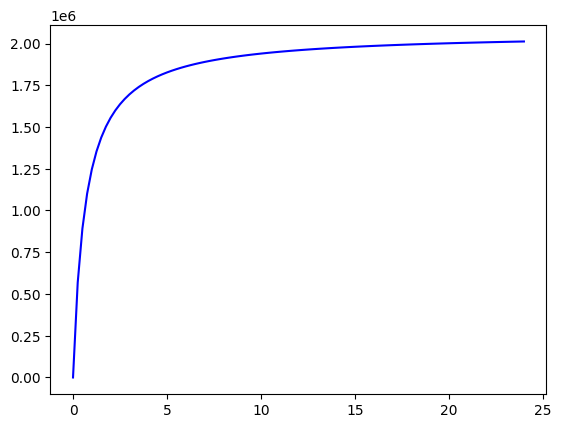

PMK


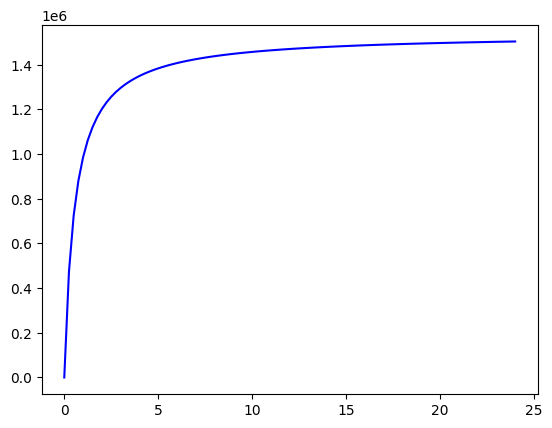

PMD


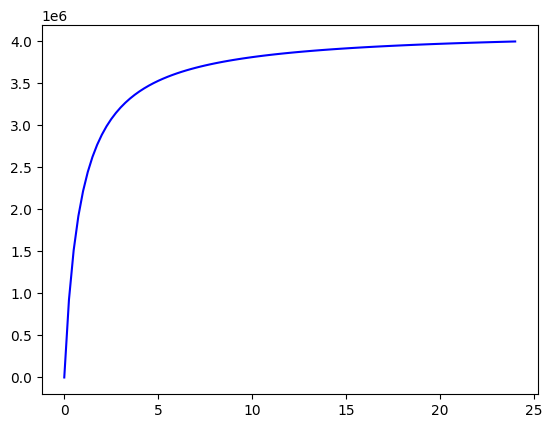

GPPS


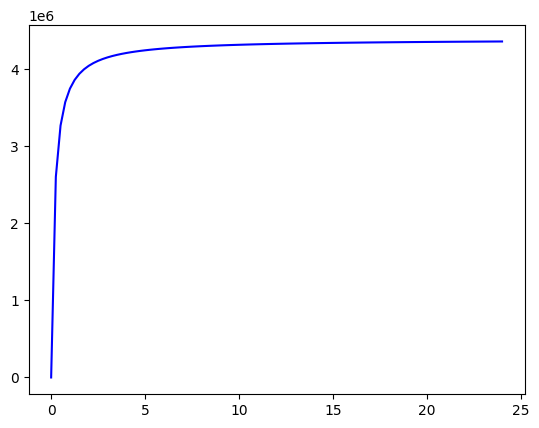

Idi


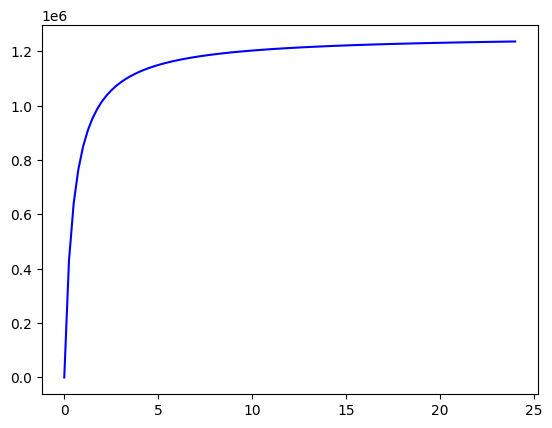

Limonene Synthase


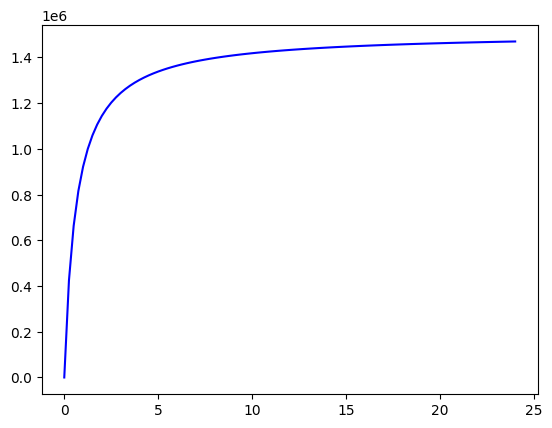

In [8]:
from KineticLearning import plotAllEnzymesTimeSeries, getAllEnzymesTimeSeries

# Evaluate time-series data for the 9 enzymes in WT 
allEnzymesTimeSeries=getAllEnzymesTimeSeries(timePoints, ke)

print('no. time series: ' + str(len(allEnzymesTimeSeries)))
print('data points in each time series:' + str(len(allEnzymesTimeSeries[1])) + '\n')

# Plot enzyme time series profiles for sanity check of ke values 
plotAllEnzymesTimeSeries(all_enzymes, allEnzymesTimeSeries,timePoints)


# --- Read in recommended strains design
1: WT
2: over-expression
0: knockdown

In [9]:

#--- manual inclusion of strains recommendation
design={} # dictionary using strain as key to hold a list of enzyme design in same order as their conc in kinetic_model
design['WT']=[1]*9 # WT design for 9 enzymes
# design['Strain_111']=[1]*4+[2]*5 # design of 1st four enzymes= 1, last five = 2
# design['Strain_222']=[0,0,0,0,2,2,2,2,2] # design of 1st four enzymes= 0, last five = 2

###--- include strain designs from ART
# remember to remove last line from recommendation file
from KineticLearning import readARTrecommendationFile
design = readARTrecommendationFile (design, all_enzymes, '4strains_initial_design_seed10.csv')

listStrains=design.keys()


ART design for Strain 1 read in:
[2, 2, 0, 2, 1, 2, 1, 1, 0]


ART design for Strain 2 read in:
[1, 0, 2, 1, 0, 0, 2, 2, 2]


ART design for Strain 3 read in:
[0, 1, 1, 0, 2, 1, 0, 0, 1]


Completed reading of
4strains_initial_design_seed10.csv
-------------------------------------------



# Translate strains design to kf/m/l values

In [10]:
# Specify which enzyme expression parameter to design
design_K = 'kf' # 'kf', 'km', 'kl'

if design_K == 'kf':
    ke_startPosition= 0
    print ('Design parameter: kf')
elif design_K == 'km':
    ke_startPosition=1
    print ('Design parameter: km')
elif design_K == 'kl':
    ke_startPosition == 2
    print ('Design parameter: kl')
else:
    print ('WARNING; ENZYME PARAMETER K(f/l/m) TO DESIGN UNCLEAR.')

Design parameter: kf


In [11]:
#--- read enzyme conc in WT
kl_WT=[]
for i in range(ke_startPosition,len(ke),3): #every 3rd value in ke starting from ke_startPosition
    kl_WT.append(ke[i])

# PRINT OUT
print ( design_K + ' for WT read in:')
print (kl_WT)
print ('\nfrom WT ke:')
print (ke)

kf for WT read in:
[2743979.608568015, 2741289.5704731075, 1818594.53615137, 2067309.1004114666, 1538319.7813797342, 4141340.591266694, 4386245.941429872, 1261146.0175475124, 1508639.88680511]

from WT ke:
[2.74397961e+06 1.23333609e-01 5.94696230e+01 2.74128957e+06
 4.78331022e-01 3.97301339e+01 1.81859454e+06 6.57343870e-01
 3.69689206e+01 2.06730910e+06 6.59020449e-01 5.76227885e+01
 1.53831978e+06 5.62220309e-01 2.65995879e+01 4.14134059e+06
 8.68577763e-01 5.44813154e+01 4.38624594e+06 1.71680929e-01
 5.54721481e+01 1.26114602e+06 4.85310095e-01 1.86877824e+01
 1.50863989e+06 6.37070778e-01 3.03410801e+01]


In [12]:
#--- translate design to enzyme conc for recommended strains
from KineticLearning import addNoise, addNoise2

design_kl={}
print ( '9 ' + design_K + ' values translated for:\n')

# biologicalNoise = 0.05

for strain in listStrains: # go thru each strain

    if len(design[strain]) == len (kl_WT):

        designList=design[strain] # get design for all enzymes (1:unchanged, 2: upreg, 0: downreg)

        # map to actual protein levels (% of WT)
        for i in range(len(designList)): #go thru each enzyme design
            if designList[i] == 2:
                designList[i]= kl_WT[i]*2.486 # 92%/37% promoter strength, Shukal et al. 2019 virifloral paper
            elif designList[i] == 0:
                designList[i]= kl_WT[i]*0.432 # 16%/37% promoter strength
            else:
                designList[i]=kl_WT[i]*1.0 # All other design assumed to be 1 (unchanged)

        # add biological noise to kl values (initial conc)
        designList = addNoise2(designList, biologicalNoise, biologicalNoiseSeed) # 0 make biologically-noisy kl values replicable
        
        design_kl[strain]=designList # store designed kl (initial enzymes conc) for each strain
        print (strain)
        print (design_kl[strain])
    else:
        print ('Number of enzymes being accounted for in design dict for ' + strain + ' not matching kl_WT list')


9 kf values translated for:

WT
[2743979.608568015, 2741289.5704731075, 1818594.53615137, 2067309.1004114666, 1538319.7813797342, 4141340.591266694, 4386245.941429872, 1261146.0175475124, 1508639.88680511]
Strain 1
[6821533.306900086, 6814845.872196146, 785632.8396173918, 5139330.423622906, 1538319.7813797342, 10295372.709889002, 4386245.941429872, 1261146.0175475124, 651732.4310998075]
Strain 2
[2743979.608568015, 1184237.0944443825, 4521026.016872306, 2067309.1004114666, 664554.1455560451, 1789059.1354272119, 10904207.410394663, 3135208.999623116, 3750478.7585975034]
Strain 3
[1185399.1909013826, 2741289.5704731075, 1818594.53615137, 893077.5313777536, 3824262.9765100195, 4141340.591266694, 1894858.2466977048, 544815.0795805254, 1508639.88680511]


# * SET initial metabolites conc

In [13]:
# initial conc -------- AcCoA,'AcAcCoA,HMG-CoA,Mev,MevP,MevPP,IPP,DMAPP,GPP,Limonene
initialMetabolitesConc = [0.3,   0.2,  0.05,  0.3, 0.02, 0.2, 0.01, 0.04, 0.05, 0] # like empirical data

# set initial limonene conc at 0, other 9 metabolites at 0.2
#initialMetabolitesConc = [0.2]*(10-1) + [0]

# biologicalNoise = 0.05
# noiseSeed =2

# add biological variations
initialMetabolitesConc = addNoise2(initialMetabolitesConc, biologicalNoise, biologicalNoiseSeed)

print ('INITIAL metabolite conc with their ordering following model reactions:\n' +str(initialMetabolitesConc))

INITIAL metabolite conc with their ordering following model reactions:
[0.3, 0.2, 0.05, 0.3, 0.02, 0.2, 0.01, 0.04, 0.05, 0.0]


# --- SET technical noise

Affects enzymes & conc measurements

Technical replicates: change 'technicalNoiseSeed' variable & rerun this & next 3 sections.

In [14]:
# Convention: technicalNoiseSeed = 0 -> no noise
#             technicalNoiseSeed = 1 -> replicate 1 with noise
#             technicalNoiseSeed = 2 -> replicate 2 with noise
#             technicalNoiseSeed = 3 -> replicate 3 with noise
# ENSURE technicalNoiseSeed & replicate variables CORRESPOND, i.e., 1 <-> '1'

technicalNoiseSeed = 0 # Any different number to generate different replicate

if technicalNoiseSeed == 0:
    noiseLevel = 0 #
else:
    noiseLevel = 50 # to change

technicalNoise = noiseLevel/1000 # Gaussian noise with standard deviation of 2.5% of underlying value
    
replicate = str(technicalNoiseSeed) + str('rep_') + str(noiseLevel) + 'noiseLevel' # Any different string to change output to a different file

print ('technical noise:' + str(technicalNoise))

technical noise:0.0


# Simulate metabolomics & proteomics time-series data for recommended strains

In [15]:
from scipy.integrate import odeint,ode
import csv

# headers for output files
CSV = [ ['Strain','Time/hours'] + all_metabolites ]
CSV2 = [ ['Strain','Time/hours'] + all_enzymes ]

sol_strain={} # dict [strain] = a list with each element holding time-series conc for a metabolite
noisy_sol_strain={} # include noise for above

#listStrains =[]
#listStrains.append('WT')



for strain in listStrains: # for each of first 8 strains
    
    designKlList=design_kl[strain]  # get its kl value for enzymes
    keList=ke # prepare its ke template

    # update ke template with its kf/m/l values
    count=0
    for i in range(ke_startPosition,len(keList),3): # every 3rd value in keList starting from ke_startPosition
        keList[i]= designKlList[count]
        count=count+1
    '''
    print ('\nke of designed strain ' + strain + ': ')
    print (keList)
    print ('Updated using designed kl')
    print (designKlList)
    '''
    
    # Build customized model
    ODE = lambda metabolites,t: kinetic_model_xtk( metabolites, t, np.append(keList, kr))
    
    # Solve for metabolite conc at various timePoints based on initialMetabolitesConc
    sol = odeint(ODE,initialMetabolitesConc,timePoints).tolist()
    sol_strain [strain]=sol
    # print (sol_strain[strain])
    
    # Include measurement noise for metabolites
    sol = addNoise(sol,technicalNoise, technicalNoiseSeed)
    noisy_sol_strain [strain] = sol
    # print (str(len(sol)) + ' time-series datapoints solved for '  + str(len(sol[0])) + ' metabolites in ' + strain + ' strain')
    
    # Metabolite print format
    lines = [  [ strain,timePoints[i] ] + line for i,line in enumerate(sol)  ]
    CSV = CSV + lines
    
    # Enzyme print format
    sol2=[]
    for t in timePoints:
        e = proteomicsData(t,keList) # get vector of enzyme conc at time t
        sol2.append(e)
    # Include measurement noise for enzymes
    sol2 = addNoise(sol2, technicalNoise, technicalNoiseSeed)
    lines2 = [  [ strain,timePoints[i] ] + line for i,line in enumerate(sol2)  ]
    CSV2 = CSV2 + lines2

print (str(len(sol)) + ' time-series datapoints solved for '  + str(len(sol[0])) + ' metabolites for all strains')

97 time-series datapoints solved for 10 metabolites for all strains


# ** Output simulated strain data to file


Technical replicates: re-run previous two sections with this one.

In [16]:
# Output simulated enzyme data to file 
fileName2 = 'data/' + replicate + '_' + shelve_name + str(len(listStrains)) + 'strains_ENZYME.csv'
with open(fileName2, 'w', newline='') as csvfile2:
    writer2 = csv.writer(csvfile2)
    writer2.writerows(CSV2)
print ('\n' + fileName2 + ' created.') 

# Output simulated metabolite data to file 
fileName =  'data/' + replicate + '_' + shelve_name + str(len(listStrains)) + 'strains_METABOLITE.csv'
with open(fileName, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(CSV)
print ('\n' + fileName + ' created.')


data/0rep_0noiseLevel_G3PCX_K_Linlog_4strains_ENZYME.csv created.

data/0rep_0noiseLevel_G3PCX_K_Linlog_4strains_METABOLITE.csv created.


# convert small negative metabolite conc. values ( magnitude < 10**-7) to e-12

i.e., simulate machine error

In [17]:
df_1=pd.read_csv(fileName)

# convert any value in file to 0 if < 0
# df_1X=df_1.apply(lambda x: x.apply(lambda y: 0 if y < 0 else y) if np.issubdtype(x.dtype, np.number) else x)

# convert any value in file to e-12 if <= 0
df_1X=df_1.apply(lambda x: x.apply(lambda y: 10**-12 if y < 0.0 else y) if np.issubdtype(x.dtype, np.number) else x)
df_1X.to_csv(fileName+'.csv', index=False)

# remove earlier file
import os
os.remove(fileName)

# Explore simulated metabolite kinetics in WT

In [18]:
# from KineticLearning import plotSimulatedKinetics
# sol_WT = noisy_sol_strain['WT']
# plotSimulatedKinetics (all_metabolites, sol_WT,timePoints)